<a href="https://colab.research.google.com/github/spencer18001/Machine-Learning-with-Graphs/blob/main/CS224W_Colab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS224W - Colab 5**

In this Colab, we will shift our focus from homogenous graphs to heterogeneous graphs. Heterogeneous graphs extend the traditional homogenous graphs that we have been working with by incorperating different node and edge types. This additional information allows us to extend the graph neural nework models that we have worked with before. Namely, we can apply heterogenous message passing, where different message types now exist between different node and edge type relationships.

In this notebook, we will first learn how to transform NetworkX graphs into DeepSNAP representations. Then, we will dive deeper into how DeepSNAP stores and represents heterogeneous graphs as PyTorch Tensors.

Lastly, we will build our own heterogenous graph neural netowrk models using PyTorch Geometric and DeepSNAP. We will then apply our models for a node property prediction task; specifically, we will evaluate these models on the heterogeneous ACM node prediction dataset.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

Have fun and good luck on Colab 5 :)

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [1]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.5.1+cu121


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
load_from_drive = True

In [4]:
if load_from_drive == False:
  !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
  !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch.__version__}+cu111.html
  !cp -r /usr/local/lib/python3.10/dist-packages/torch_scatter /content/drive/MyDrive/torch_packages/torch_scatter
  !cp -r /usr/local/lib/python3.10/dist-packages/torch_sparse /content/drive/MyDrive/torch_packages/torch_sparse
else:
  !cp -r /content/drive/MyDrive/torch_packages/torch_scatter /usr/local/lib/python3.10/dist-packages/
  !cp -r /content/drive/MyDrive/torch_packages/torch_sparse /usr/local/lib/python3.10/dist-packages/

In [5]:
# Install torch geometric
if 'IS_GRADESCOPE_ENV' not in os.environ:
#   torch_version = str(torch.__version__)
#   scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
#   sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
#   !pip install torch-scatter -f $scatter_src
#   !pip install torch-sparse -f $sparse_src
  !pip install torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git
  !pip install -U -q PyDrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [6]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !nvcc --version
  !python -c "import torch; print(torch.version.cuda)"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
12.1


In [7]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
#   import torch
#   print(torch.__version__)
  import torch_geometric
  print(torch_geometric.__version__)

2.6.1


# DeepSNAP Basics

In previous Colabs we used both of graph class (NetworkX) and tensor (PyG) representations of graphs separately. The graph class `nx.Graph` provides rich analysis and manipulation functionalities, such as the clustering coefficient and PageRank. To feed the graph into the model, we need to transform the graph into tensor representations including edge tensor `edge_index` and node attributes tensors `x` and `y`. But only using tensors (as the graphs formatted in PyG `datasets` and `data`) will make many graph manipulations and analysis less efficient and harder. So, in this Colab we will use DeepSNAP which combines both representations and offers a full pipeline for GNN training / validation / testing.


In general, [DeepSNAP](https://github.com/snap-stanford/deepsnap) is a Python library to assist efficient deep learning on graphs. DeepSNAP features in its support for flexible graph manipulation, standard pipeline, heterogeneous graphs and simple API.

1. DeepSNAP is easy to be used for the sophisticated graph manipulations, such as feature computation, pretraining, subgraph extraction etc. during/before the training.
2. In most frameworks, standard pipelines for node, edge, link, graph-level tasks under inductive or transductive settings are left to the user to code. In practice, there are additional design choices involved (such as how to split dataset for link prediction). DeepSNAP provides such a standard pipeline that greatly saves repetitive coding efforts, and enables fair comparision for models.
3. Many real-world graphs are heterogeneous graphs. But packages support for heterogeneous graphs, including data storage and flexible message passing, is lacking. DeepSNAP provides an efficient and flexible heterogeneous graph that supports both the node and edge heterogeneity.

[DeepSNAP](https://github.com/snap-stanford/deepsnap) is a newly released project and it is still under development. If you find any bugs or have any improvement ideas, feel free to raise issues or create pull requests on the GitHub directly :)

In this Colab, we will focus on learning using Heterogeneous Graphs. Not many libraries are able to handle heterogeneous graphs, but DeepSNAP handles them quite elegantly, which is why we're introducing it here!

# 1) DeepSNAP Heterogeneous Graph

First, we will explore how to transform a NetworkX graph into the format supported by DeepSNAP.

In DeepSNAP we have three levels of attributes. We can have **node level** attributes including `node_feature` and `node_label`. The other two levels of attributes are graph and edge attributes. The usage is similar to the node level one except that the feature becomes `edge_feature` or `graph_feature` and label becomes `edge_label` or `graph_label` etc.

DeepSNAP extends its traditional graph representation to include heterogeneous graphs by including the following graph property features:  
* `node_feature`: The feature of each node (`torch.tensor`)
* `edge_feature`: The feature of each edge (`torch.tensor`)
* `node_label`: The label of each node (`int`)
* `node_type`: The node type of each node (`string`)
* `edge_type`: The edge type of each edge (`string`)

where the key **new** features we add are `node_type` and `edge_type`, which enables us to perform heterogenous message passing.

For this first question we will work with the familiar [karate club graph](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html) seen in Colab 1. To start, since each node in the graph belongs to one of two clubs (club "Mr. Hi" or club "Officer"), we will treat the club as the `node_type`. The code below demonstrates how to differentiate the nodes in the NetworkX graph.


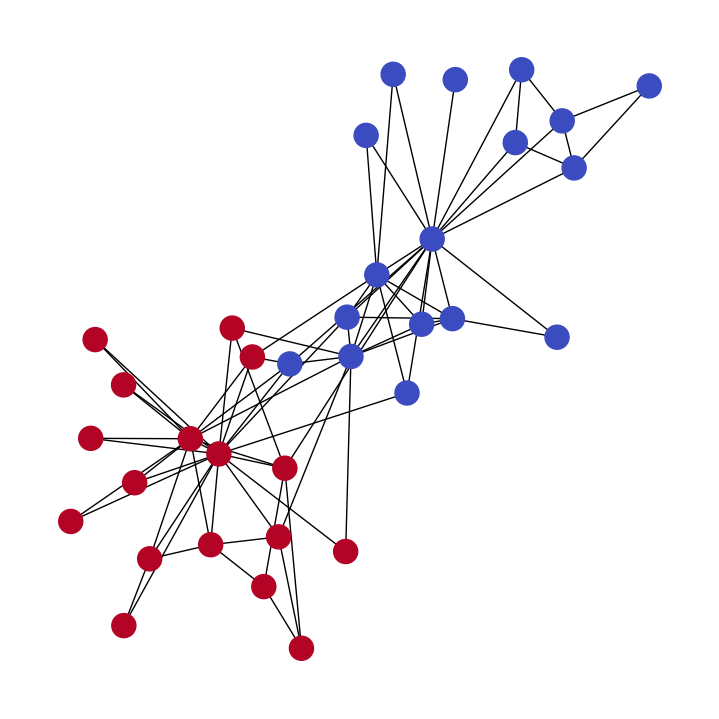

In [8]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

if 'IS_GRADESCOPE_ENV' not in os.environ:
  from pylab import show

  # Zachary's Karate Club 社交網路數據集，包含 34 個節點和 78 條邊，表示 34 個成員間的互動關係
  # 每個節點具有屬性 club，表示該成員所屬的俱樂部（"Mr. Hi" 或 "Officer"）
  G = nx.karate_club_graph()

  community_map = {}
  for node in G.nodes(data=True): # node 為 (node, data)
    if node[1]["club"] == "Mr. Hi":
      community_map[node[0]] = 0
    else:
      community_map[node[0]] = 1

  color_map = {0: 0, 1: 1}
  node_color = []
  node_color = [color_map[community_map[node]] for node in G.nodes()]

  # 基於物理模擬的圖形佈局演算法，讓節點根據連接關係以彈簧力的方式排列
  pos = nx.spring_layout(G)
  plt.figure(figsize=(7, 7))
  nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
  show()

### Question 1.1: Assigning Node Type and Node Features

Using the `community_map` dictionary and graph `G` from above, add node attributes `node_type` and `node_label` to the graph G. Namely, for `node_type` assign nodes in the "Mr. Hi" club to a node type `n0` and nodes in club "Officer" a node type `n1`. Note: the node type should be a `string` property.

Then for `node_label`, assign nodes in "Mr. Hi" club to a `node_label` `0` and nodes in club "Officer" a `node_label` of `1`.

Lastly, assign every node the *tensor* feature vector $[1, 1, 1, 1, 1]$.

**Hint**: Look at the NetworkX function `nx.classes.function.set_node_attributes`.

**Note**: This question is not specifically graded but is important for later questions.

In [9]:
import torch

def assign_node_types(G, community_map):
  # TODO: Implement a function that takes in a NetworkX graph
  # G and community map assignment (mapping node id --> 0/1 label)
  # and adds 'node_type' as a node_attribute in G.

  ############# Your code here ############
  ## (~2 line of code) It's alright if you take up more lines!
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
  ## 2. Look above for the two node type values!

  node_types = {node: 'n0' if community == 0 else 'n1' for node, community in community_map.items()}
  nx.set_node_attributes(G, node_types, name='node_type')

  #########################################

def assign_node_labels(G, community_map):
  # TODO: Implement a function that takes in a NetworkX graph
  # G and community map assignment (mapping node id --> 0/1 label)
  # and adds 'node_label' as a node_attribute in G.

  ############# Your code here ############
  ## (~2 line of code) It's alright if you take up more lines!
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`

  nx.set_node_attributes(G, community_map, name='node_label')

  #########################################

def assign_node_features(G):
  # TODO: Implement a function that takes in a NetworkX graph
  # G and adds 'node_feature' as a node_attribute in G. Each node
  # in the graph has the same feature vector - a torchtensor with
  # data [1., 1., 1., 1., 1.]

  ############# Your code here ############
  ## (~2 line of code) It's alright if you take up more lines!
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`

  node_features = {node: torch.tensor([1., 1., 1., 1., 1.]) for node in G.nodes()}
  nx.set_node_attributes(G, node_features, name='node_feature')

  #########################################

if 'IS_GRADESCOPE_ENV' not in os.environ:
  assign_node_types(G, community_map)
  assign_node_labels(G, community_map)
  assign_node_features(G)

  # Explore node properties for the node with id: 20
  node_id = 20
  print (f"Node {node_id} has properties:", G.nodes(data=True)[node_id])

Node 20 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': tensor([1., 1., 1., 1., 1.])}


### Question 1.2: Assigning Edge Types

Next, we will assign three different `edge_types`:
* Edges within club "Mr. Hi": `e0`
* Edges within club "Officer": `e1`
* Edges between the two clubs: `e2`

**Hint**: Use the `community_map` from before and `nx.classes.function.set_edge_attributes`

In [10]:
def assign_edge_types(G, community_map):
  # TODO: Implement a function that takes in a NetworkX graph
  # G and community map assignment (mapping node id --> 0/1 label)
  # and adds 'edge_type' as a edge_attribute in G.

  ############# Your code here ############
  ## (~5 line of code) It's alright if you take up more lines!
  ## Note
  ## 1. Create an edge assignment dict following rules above
  ## 2. Look up NetworkX `nx.classes.function.set_edge_attributes`

  edge_types = {}
  for u, v in G.edges():
    if community_map[u] == community_map[v]:
      edge_type = 'e0' if community_map[u] == 0 else 'e1'
    else:
      edge_type = 'e2'
    edge_types[(u, v)] = edge_type

  nx.set_edge_attributes(G, edge_types, name='edge_type')

  #########################################

if 'IS_GRADESCOPE_ENV' not in os.environ:
  assign_edge_types(G, community_map)

  # Explore edge properties for a sampled edge and check the corresponding node types
  edge_idx = 15
  n1 = 0
  n2 = 31
  edge = list(G.edges(data=True))[edge_idx] # edge 為 (n1, n2, data)
  print (f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
  print (f"Node {n1} has properties:", G.nodes(data=True)[n1])
  print (f"Node {n2} has properties:", G.nodes(data=True)[n2])

Edge (0, 31) has properties: {'weight': 2, 'edge_type': 'e2'}
Node 0 has properties: {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': tensor([1., 1., 1., 1., 1.])}
Node 31 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': tensor([1., 1., 1., 1., 1.])}


## Heterogeneous Graph Visualization

Now we can visualize the Heterogeneous Graph we have generated.

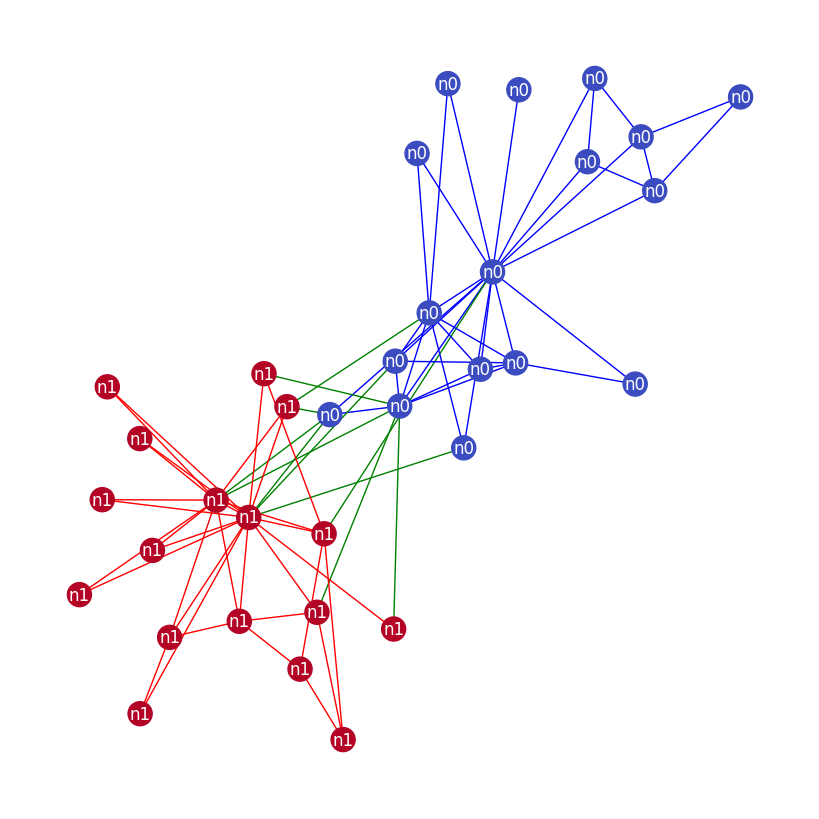

In [11]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  edge_color = {}
  for edge in G.edges():
    n1, n2 = edge
    edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
    if community_map[n1] == community_map[n2] and community_map[n1] == 0:
      edge_color[edge] = 'blue'
    elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
      edge_color[edge] = 'red'
    else:
      edge_color[edge] = 'green'

  G_orig = copy.deepcopy(G)
  nx.classes.function.set_edge_attributes(G, edge_color, name='color')
  colors = nx.get_edge_attributes(G, 'color').values()
  labels = nx.get_node_attributes(G, 'node_type')
  plt.figure(figsize=(8, 8))
  nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
  show()

where we differentiate edges within each clubs (2 types) and edges between the two clubs (1 type). Different types of nodes and edges are visualized in different colors. The NetworkX object `G` in following code can be transformed into `deepsnap.hetero_graph.HeteroGraph` directly.

## Transforming to DeepSNAP representation

We will now work through transforming the NetworkX object `G` into a `deepsnap.hetero_graph.HeteroGraph`.

In [12]:
from deepsnap.hetero_graph import HeteroGraph

if 'IS_GRADESCOPE_ENV' not in os.environ:
  hete = HeteroGraph(G_orig)

## Question 1.3: How many nodes are of each type (10 Points)


In [13]:
def get_nodes_per_type(hete):
  # TODO: Implement a function that takes a DeepSNAP dataset object
  # and return the number of nodes per `node_type`.

  num_nodes_n0 = 0
  num_nodes_n1 = 0

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful. Explore the attributes of HeteroGraph class.

  num_nodes_n0 = len(hete.node_type['n0'])
  num_nodes_n1 = len(hete.node_type['n1'])

  #########################################

  return num_nodes_n0, num_nodes_n1

if 'IS_GRADESCOPE_ENV' not in os.environ:
  num_nodes_n0, num_nodes_n1 = get_nodes_per_type(hete)
  print("Node type n0 has {} nodes".format(num_nodes_n0))
  print("Node type n1 has {} nodes".format(num_nodes_n1))

Node type n0 has 17 nodes
Node type n1 has 17 nodes


## Question 1.4: Message Types - How many edges are of each message type (10 Points)

When working with heterogenous graphs, as we have discussed before, we now work with heterogenous message types (i.e. different message types for the different `node_type` and `edge_type` combinations). For example, an edge of type `e0` connecting two nodes in club "Mr. HI" would have a message type of (`n0`, `e0`, `n0`). In this problem we will analyze how many edges in our graph are of each message type.

**Hint**: If you want to learn more about what the different message types are try the call `hete.message_types`

In [14]:
def get_num_message_edges(hete):
  # TODO: Implement this function that takes a DeepSNAP dataset object
  # and return the number of edges for each message type.
  # You should return a list of tuples as
  # (message_type, num_edge)

  message_type_edges = []

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful. Explore the attributes of HeteroGraph class.

  message_type_edges = [
    (message_type, len(hete.edge_label_index[message_type].T))
    for message_type in hete.message_types
  ]

  #########################################

  return message_type_edges

if 'IS_GRADESCOPE_ENV' not in os.environ:
  message_type_edges = get_num_message_edges(hete)
  for (message_type, num_edges) in message_type_edges:
    print("Message type {} has {} edges".format(message_type, num_edges))

Message type ('n0', 'e0', 'n0') has 70 edges
Message type ('n0', 'e2', 'n1') has 22 edges
Message type ('n1', 'e1', 'n1') has 64 edges


## Question 1.5: Dataset Splitting - How many nodes are in each dataset split? (10 Points)

DeepSNAP has built in Dataset creation and splitting methods for heterogeneous graphs. Here we will create train, validation, and test datasets for a node prediction task and inspect the resulting subgraphs. Specifically, write a function that computes the number of nodes with a known label in each dataset split.


In [15]:
from deepsnap.dataset import GraphDataset

def compute_dataset_split_counts(datasets):
  # TODO: Implement a function that takes a dict of datasets in the form
  # {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}
  # and returns a dict mapping dataset names to the number of labeled
  # nodes used for supervision in that respective dataset.

  data_set_splits = {}

  ############# Your code here ############
  ## (~3 line of code)
  ## Note
  ## 1. The DeepSNAP `node_label_index` dictionary will be helpful.
  ## 2. Remember to count both node_types
  ## 3. Remember each dataset only has one graph that we need to access
  ##    (i.e. dataset[0])

  for split_name, dataset in datasets.items():
    graph = dataset[0]
    # node_label_index 為 (node_type->indices)
    num_labeled_nodes = sum(len(indices) for indices in graph.node_label_index.values())
    data_set_splits[split_name] = num_labeled_nodes

  #########################################

  return data_set_splits

if 'IS_GRADESCOPE_ENV' not in os.environ:
  dataset = GraphDataset([hete], task='node')
  # Splitting the dataset
  dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
  datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

  data_set_splits = compute_dataset_split_counts(datasets)
  for dataset_name, num_nodes in data_set_splits.items():
    print("{} dataset has {} nodes".format(dataset_name, num_nodes))

train dataset has 12 nodes
val dataset has 10 nodes
test dataset has 12 nodes


## DeepSNAP Dataset Visualization

We can now visualize the different nodes and edges used in each graph dataset split.

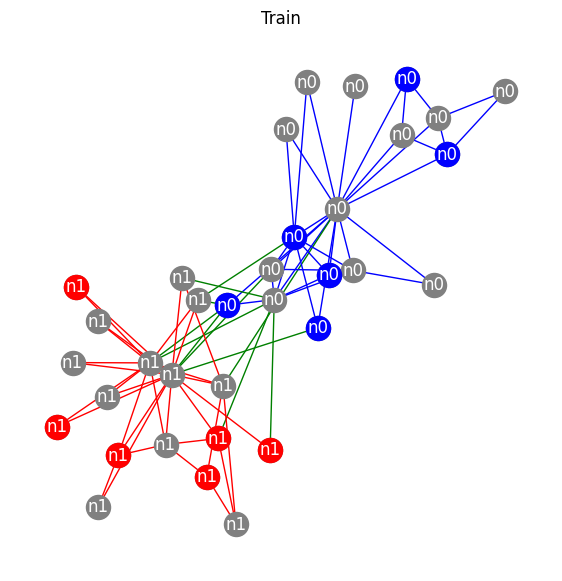

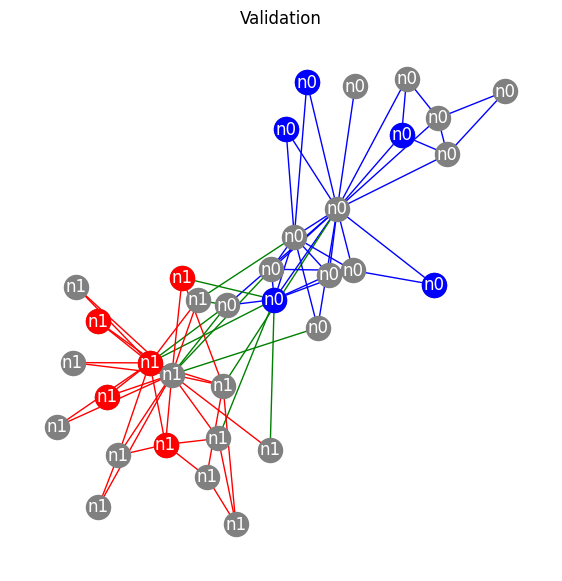

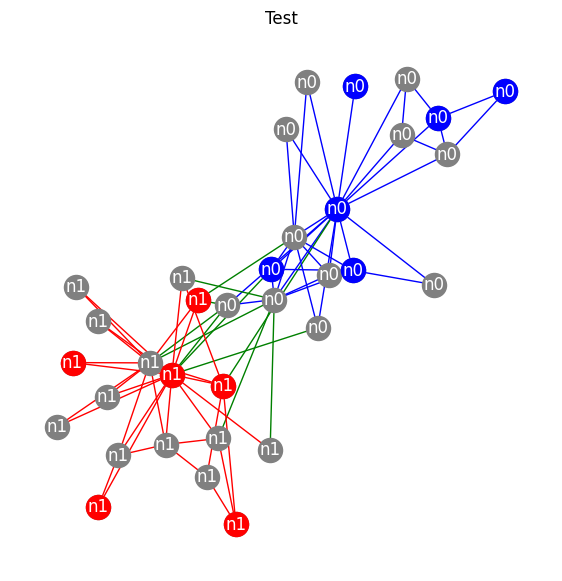

In [16]:
from deepsnap.dataset import GraphDataset

if 'IS_GRADESCOPE_ENV' not in os.environ:
  dataset = GraphDataset([hete], task='node')
  # Splitting the dataset
  dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
  titles = ['Train', 'Validation', 'Test']

  for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    # _convert_to_graph_index 將 DeepSNAP 的內部節點索引轉換回原始圖的節點索引，這樣可以與原始 NetworkX 圖進行對應
    n0 = hete._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
    n1 = hete._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

    plt.figure(figsize=(7, 7))
    plt.title(titles[i])
    nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
    nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
    nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
    show()

# 2) Heterogeneous Graph Node Property Prediction

Now, we will use PyTorch Geometric and DeepSNAP to implement a GNN model for heterogeneous graph node property prediction (node classification). We will draw upon our understanding of heterogeneous graphs from lecture and previous work in implementing GNN layers using PyG (introduced in Colab 3).

First let's take a look at the general structure of a heterogeneous GNN layer by working through an example:

Let's assume we have a graph $G$, which contains two node types $a$ and $b$, and three message types $m_1=(a, r_1, a)$, $m_2=(a, r_2, b)$ and $m_3=(a, r_3, b)$. Note: during message passing we view each message as (src, relation, dst), where messages "flow" from src to dst node types. For example, during message passing, updating node type $b$ relies on two different message types $m_2$ and $m_3$.

When applying message passing in heterogenous graphs, we seperately apply message passing over each message type. Therefore, for the graph $G$, a heterogeneous GNN layer contains three seperate Heterogeneous Message Passing layers (`HeteroGNNConv` in this Colab), where each `HeteroGNNConv` layer performs message passing and aggregation with respect to *only one message type*. Since a message type is viewed as (src, relation, dst) and messages "flow" from src to dst, each `HeteroGNNConv` layer only computes embeddings for the *dst* nodes of a given message type. For example, the `HeteroGNNConv` layer for message type $m_2$ outputs updated embedding representations *only* for node's with type b.

---

An overview of the heterogeneous layer we will create is shown below:

![test](https://drive.google.com/uc?export=view&id=1mkp4OeRrvC4iNFTXSywrmI6Pfl5J__gA)

where we highlight the following notation:

- $H_a^{(l)[m_1]}$ is the intermediate matrix of of node embeddings for node type $a$, generated by the $l$th `HeteroGNNConv` layer for message type $m_1$.
- $H_a^{(l)}$ is the matrix with current embeddings for nodes of type $a$ after the $l$th layer of our Heterogeneous GNN model. Note that these embeddings can rely on one or more intermediate `HeteroGNNConv` layer embeddings(i.e. $H_b^{(l)}$ combines $H_b^{(l)[m_2]}$ and $H_b^{(l)[m_3]}$).

Since each `HeteroGNNConv` is only applied over a single message type, we additionally define a Heterogeneous GNN Wrapper layer (`HeteroGNNWrapperConv`). This wrapper manages and combines the output of each `HeteroGNNConv` layer in order to generate the complete updated node embeddings for each node type in layer $l$ of our model. More specifically, the $l^{th}$ `HeteroGNNWrapperConv` layer takes as input the node embeddings computed for each message type and node type (e.g. $H_b^{(l)[m_2]}$ and $H_b^{(l)[m_3]}$) and aggregates across message types with the same $dst$ node type. The resulting output of the $l^{th}$ `HeteroGNNWrapperConv` layer is the updated embedding matrix $H_i^{(l)}$ for each node type i.

Continuing on our example above, to compute the node embeddings $H_b^{(l)}$ the wrapper layer aggregates output embeddings from the `HeteroGNNConv` layers associated with message types $m_2$ and $m_3$ (i.e. $H_b^{(l)[m_2]}$ and $H_b^{(l)[m_3]}$).

---

With the `HeteroGNNWrapperConv` module, we can now draw a "simplified" heterogeneous layer structure as follows:

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/hetero_conv_1.png"/>
</center>
<br/>

---
**NOTE**:
As reference, it may be helpful to additionally read through PyG's introduciton to heterogeneous graph representations and buidling heterogeneous GNN models: https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html

<font color='red'>Looking ahead, we recommend you implement the heterogeneous GNN model in following steps:</font>

1. Implement `HeteroGNNConv`.
2. Implement **just** `mean` aggregation within `HeteroGNNWrapperConv`.
3. Implement `generate_convs`.
4. Implement the `HeteroGNN` model and the `train` function.
5. Train the model with `mean` aggregation and test your model to make sure your model has reasonable performance.
6. Once you are confident in your mean aggregation model, implement `attn` aggregation in `HeteroGNNWrapperConv`.
7. Train the model with `attn` aggregation and test your model to make sure your model has reasonable performance.

Note: The key point of advice is to work completely through implementing the mean aggregation heterogeneous GNN model before diving into the more difficult attention based model.

## Setup

In [ ]:
import copy
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul

## Dataset

You need to login to your Google account and enter the verification code below.

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  # Authenticate and create the PyDrive client
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  id='1ivlxd6lJMcZ9taS44TMGG72x2V1GeVvk'
  downloaded = drive.CreateFile({'id': id})
  downloaded.GetContentFile('acm.pkl')

## Implementing `HeteroGNNConv`

Now let's start working on our own implementation of the heterogeneous message passing layer (`HeteroGNNConv`)! Just as in Colabs 3 and 4, we will implement the layer using PyTorch Geometric.

At a high level, the `HeteroGNNConv` layer is equivalent to the homogenous GNN layers we implemented in Colab 3, but now applied to an individual heterogeous message type. Moreover, our heterogeneous GNN layer draws directly from the **GraphSAGE** message passing model ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)).

We begin by defining the `HeteroGNNConv` layer with respect to message type $m$:

\begin{equation}
m =(s, r, d)
\end{equation}

where each message type is a tuple containing three elements: $s$ - the source node type, $r$ - the edge (relation) type, and $d$ - the destination node type.

The message passing update rule that we implement is very similar to that of GraphSAGE, except we now need to include the node types and the edge relation type. The update rule for message type $m$ is described below:

\begin{equation}
h_v^{(l)[m]} = W^{(l)[m]} \cdot \text{CONCAT} \Big( W_d^{(l)[m]} \cdot h_v^{(l-1)}, W_s^{(l)[m]} \cdot AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \})\Big)
\end{equation}

where we compute $h_v^{(l)[m]}$, the node embedding representation for node $v$ after `HeteroGNNConv` layer $l$ with respect message type $m$. Further unpacking the forumla we have:
- $W_s^{(l)[m]}$ - linear transformation matrix for the messages of neighboring source nodes of type $s$ along message type $m$.
- $W_d^{(l)[m]}$ - linear transformation matrix for the message from the node $v$ itself of type $d$.
- $W^{(l)[m]}$ - linear transformation matrix for the concatenated messages from neighboring node's and the central node.
- $h_u^{(l-1)}$ - the hidden embedding representation for node $u$ after the $(l-1)$th `HeteroGNNWrapperConv` layer. Note, that this embedding is not associated with a particular message type (see layer diagrams above).
- $N_{m}(v)$ - the set of neighbor source nodes $s$ for the node v that we are embedding along message type $m = (s, r, d)$.

**NOTE**: We emphasize that each weight matrix is associated with a specific message type $[m]$ and additionally, the weight matrices applied to node messages are differentiated by node type (i.e. $W_s$ and $W_d$).

Lastly, for simplicity, we use mean aggregations for $AGG$ where:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \}) = \frac{1}{|N_{m}(v)|} \sum_{u\in N_{m}(v)} h_u^{(l-1)}
\end{equation}

In [ ]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        # To simplify implementation, please initialize both self.lin_dst
        # and self.lin_src out_features to out_channels
        self.lin_dst = None
        self.lin_src = None

        self.lin_update = None

        ############# Your code here #############
        ## (~3 lines of code)
        ## Note:
        ## 1. Initialize the 3 linear layers.
        ## 2. Think through the connection between the mathematical
        ##    definition of the update rule and torch linear layers!

        pass


        ##########################################

    def forward(
        self,
        node_feature_src,
        node_feature_dst,
        edge_index,
        size=None
    ):
        ############# Your code here #############
        ## (~1 line of code)
        ## Note:
        ## 1. Unlike Colabs 3 and 4, we just need to call self.propagate with
        ## proper/custom arguments.

        pass

        ##########################################

    def message_and_aggregate(self, edge_index, node_feature_src):

        out = None
        ############# Your code here #############
        ## (~1 line of code)
        ## Note:
        ## 1. Different from what we implemented in Colabs 3 and 4, we use message_and_aggregate
        ##    to combine the previously seperate message and aggregate functions.
        ##    The benefit is that we can avoid materializing x_i and x_j
        ##    to make the implementation more efficient.
        ## 2. To implement efficiently, refer to PyG documentation for message_and_aggregate
        ##    and sparse-matrix multiplication:
        ##    https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
        ## 3. Here edge_index is torch_sparse SparseTensor. Although interesting, you
        ##    do not need to deeply understand SparseTensor represenations!
        ## 4. Conceptually, think through how the message passing and aggregation
        ##    expressed mathematically can be expressed through matrix multiplication.

        pass


        ##########################################

        return out

    def update(self, aggr_out, node_feature_dst):

        ############# Your code here #############
        ## (~4 lines of code)
        ## Note:
        ## 1. The update function is called after message_and_aggregate
        ## 2. Think through the one-one connection between the mathematical update
        ##    rule and the 3 linear layers defined in the constructor.

       pass


        ##########################################

        return aggr_out

## Heterogeneous GNN Wrapper Layer

After implementing the `HeteroGNNConv` layer for each message type, we need to manage and aggregate the node embedding results (with respect to each message types). Here we will implement two types of message type level aggregation.

The first one is simply mean aggregation over message types:

\begin{equation}
h_v^{(l)} = \frac{1}{M}\sum_{m=1}^{M}h_v^{(l)[m]}
\end{equation}

where node $v$ has node type $d$ and we sum over the $M$ message types that have destination node type $d$. From our original example, for a node v of type $b$ we aggregate v's `HeteroGNNConv` embeddings for message types $m_2$ and $m_3$ (i.e. $h_v^{(l)[m_2]}$ and $h_v^{(l)[m_3]}$).

The second method we implement is the semantic level attention introduced in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)). Instead of directly averaging on the message type aggregation results, we use attention to learn which message type result is more important, then aggregate across all the message types. Below are the equations for semantic level attention:

\begin{equation}
e_{m} = \frac{1}{|V_{d}|} \sum_{v \in V_{d}} q_{attn}^T \cdot tanh \Big( W_{attn}^{(l)} \cdot h_v^{(l)[m]} + b \Big)
\end{equation}

where $m$ is the message type and $d$ refers to the destination node type for that message ($m = (s, r, d)$). Additionally, $V_{d}$ refers to the set of nodes v with type $d$. Lastly, the unormalized attention weight $e_m$ is a scaler computed for each message type $m$.

Next, we can compute the normalized attention weights and update $h_v^{(l)}$:

\begin{equation}
\alpha_{m} = \frac{\exp(e_{m})}{\sum_{m=1}^M \exp(e_{m})}
\end{equation}

\begin{equation}
h_v^{(l)} = \sum_{m=1}^{M} \alpha_{m} \cdot h_v^{(l)[m]}
\end{equation}

, where we emphasize that $M$ here is the number of message types associated with the destination node type $d$.

**Note**: The implementation of the attention aggregation is tricky and nuanced. We strongly recommend working carefully through the math equations to undersatnd exactly what each notation refers to and how all the pieces fit together. If you can, try to connect the math to our original example, focusing on node type $b$, which depends on two different message types!

**_We've implemented most of this for you but you'll need to initialize self.attn_proj in the initializer_**

In [ ]:
class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

        # A numpy array that stores the final attention probability
        self.alpha = None

        self.attn_proj = None

        if self.aggr == "attn":
            ############# Your code here #############
            ## (~1 line of code)
            ## Note:
            ## 1. Initialize self.attn_proj, where self.attn_proj should include
            ##    two linear layers. Note, make sure you understand
            ##    which part of the equation self.attn_proj captures.
            ## 2. You should use nn.Sequential for self.attn_proj
            ## 3. nn.Linear and nn.Tanh are useful.
            ## 4. You can model a weight vector (rather than matrix) by using:
            ##    nn.Linear(some_size, 1, bias=False).
            ## 5. The first linear layer should have out_features as args['attn_size']
            ## 6. You can assume we only have one "head" for the attention.
            ## 7. We recommend you to implement the mean aggregation first. After
            ##    the mean aggregation works well in the training, then you can
            ##    implement this part.

            pass

            ##########################################

    def reset_parameters(self):
        super(HeteroConvWrapper, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()

    def forward(self, node_features, edge_indices):
        message_type_emb = {}
        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            message_type_emb[message_key] = (
                self.convs[message_key](
                    node_feature_src,
                    node_feature_dst,
                    edge_index,
                )
            )
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb

    def aggregate(self, xs):
        # TODO: Implement this function that aggregates all message type results.
        # Here, xs is a list of tensors (embeddings) with respect to message
        # type aggregation results.

        if self.aggr == "mean":

            ############# Your code here #############
            ## (~2 lines of code)
            ## Note:
            ## 1. Explore the function parameter `xs`!

            pass

            ##########################################

        elif self.aggr == "attn":
            N = xs[0].shape[0] # Number of nodes for that node type
            M = len(xs) # Number of message types for that node type

            x = torch.cat(xs, dim=0).view(M, N, -1) # M * N * D
            z = self.attn_proj(x).view(M, N) # M * N * 1
            z = z.mean(1) # M * 1
            alpha = torch.softmax(z, dim=0) # M * 1

            # Store the attention result to self.alpha as np array
            self.alpha = alpha.view(-1).data.cpu().numpy()

            alpha = alpha.view(M, 1, 1)
            x = x * alpha
            return x.sum(dim=0)

## Initialize Heterogeneous GNN Layers

Now let's put it all together and initialize the Heterogeneous GNN Layers. Different from the homogeneous graph case, heterogeneous graphs can be a little bit complex.

In general, we need to create a dictionary of `HeteroGNNConv` layers where the keys are message types.

* To get all message types, `deepsnap.hetero_graph.HeteroGraph.message_types` is useful.
* If we are initializing the first conv layers, we need to get the feature dimension of each node type. Using `deepsnap.hetero_graph.HeteroGraph.num_node_features(node_type)` will return the node feature dimension of `node_type`. In this function, we will set each `HeteroGNNConv` `out_channels` to be `hidden_size`.
* If we are not initializing the first conv layers, all node types will have the smae embedding dimension `hidden_size` and we still set `HeteroGNNConv` `out_channels` to be `hidden_size` for simplicity.



In [ ]:
def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    # TODO: Implement this function that returns a dictionary of `HeteroGNNConv`
    # layers where the keys are message types. `hetero_graph` is deepsnap `HeteroGraph`
    # object and the `conv` is the `HeteroGNNConv`.

    convs = {}

    ############# Your code here #############
    ## (~9 lines of code)
    ## Note:
    ## 1. See the hints above!
    ## 2. conv is of type `HeteroGNNConv`

    pass


    ##########################################

    return convs

## HeteroGNN

Now we will make a simple HeteroGNN model which contains only two `HeteroGNNWrapperConv` layers.

For the forward function in `HeteroGNN`, the model is going to be run as following:

$\text{self.convs1} \rightarrow \text{self.bns1} \rightarrow \text{self.relus1} \rightarrow \text{self.convs2} \rightarrow \text{self.bns2} \rightarrow \text{self.relus2} \rightarrow \text{self.post_mps}$

In [ ]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()

        self.aggr = aggr
        self.hidden_size = args['hidden_size']

        self.convs1 = None
        self.convs2 = None

        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()

        ############# Your code here #############
        ## (~10 lines of code)
        ## Note:
        ## 1. For self.convs1 and self.convs2, call generate_convs at first and then
        ##    pass the returned dictionary of `HeteroGNNConv` to `HeteroGNNWrapperConv`.
        ## 2. For self.bns, self.relus and self.post_mps, the keys are node_types.
        ##    `deepsnap.hetero_graph.HeteroGraph.node_types` will be helpful.
        ## 3. Initialize all batchnorms to torch.nn.BatchNorm1d(hidden_size, eps=1).
        ## 4. Initialize all relus to nn.LeakyReLU().
        ## 5. For self.post_mps, each value in the ModuleDict is a linear layer
        ##    where the `out_features` is the number of classes for that node type.
        ##    `deepsnap.hetero_graph.HeteroGraph.num_node_labels(node_type)` will be
        ##    useful.

        pass


        ##########################################

    def forward(self, node_feature, edge_index):
        # TODO: Implement the forward function. Notice that `node_feature` is
        # a dictionary of tensors where keys are node types and values are
        # corresponding feature tensors. The `edge_index` is a dictionary of
        # tensors where keys are message types and values are corresponding
        # edge index tensors (with respect to each message type).

        x = node_feature

        ############# Your code here #############
        ## (~7 lines of code)
        ## Note:
        ## 1. `deepsnap.hetero_gnn.forward_op` can be helpful.

        pass


        ##########################################

        return x

    def loss(self, preds, y, indices):

        loss = 0
        loss_func = F.cross_entropy

        ############# Your code here #############
        ## (~3 lines of code)
        ## Note:
        ## 1. For each node type in preds, accumulate computed loss to `loss`
        ## 2. Loss need to be computed with respect to the given index
        ## 3. preds is a dictionary of model predictions keyed by node_type.
        ## 4. indeces is a dictionary of labeled supervision nodes keyed
        ##    by node_type

        pass


        ##########################################

        return loss

## Training and Testing

Here we provide you with the functions to train and test. You only need to implement one line of code here.

**Please do not modify other parts in `train` and `test` for grading purposes.**

In [ ]:
import pandas as pd

def train(model, optimizer, hetero_graph, train_idx):
    model.train()
    optimizer.zero_grad()
    preds = model(hetero_graph.node_feature, hetero_graph.edge_index)

    loss = None

    ############# Your code here #############
    ## Note:
    ## 1. Compute the loss here
    ## 2. `deepsnap.hetero_graph.HeteroGraph.node_label` is useful

    pass


    ##########################################

    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, graph, indices, best_model=None, best_val=0, save_preds=False, agg_type=None):
    model.eval()
    accs = []
    for i, index in enumerate(indices):
        preds = model(graph.node_feature, graph.edge_index)
        num_node_types = 0
        micro = 0
        macro = 0
        for node_type in preds:
            idx = index[node_type]
            pred = preds[node_type][idx]
            pred = pred.max(1)[1]
            label_np = graph.node_label[node_type][idx].cpu().numpy()
            pred_np = pred.cpu().numpy()
            micro = f1_score(label_np, pred_np, average='micro')
            macro = f1_score(label_np, pred_np, average='macro')
            num_node_types += 1

        # Averaging f1 score might not make sense, but in our example we only
        # have one node type
        micro /= num_node_types
        macro /= num_node_types
        accs.append((micro, macro))

        # Only save the test set predictions and labels!
        if save_preds and i == 2:
          print ("Saving Heterogeneous Node Prediction Model Predictions with Agg:", agg_type)
          print()

          data = {}
          data['pred'] = pred_np
          data['label'] = label_np

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('ACM-Node-' + agg_type + 'Agg.csv', sep=',', index=False)

    if accs[1][0] > best_val:
        best_val = accs[1][0]
        best_model = copy.deepcopy(model)
    return accs, best_model, best_val

In [ ]:
# Please do not change the following parameters
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.003,
    'attn_size': 32,
}

## Dataset and Preprocessing

In the next, we will load the data and create a tensor backend (without a NetworkX graph) `deepsnap.hetero_graph.HeteroGraph` object.

We will use the `ACM(3025)` dataset in our node property prediction task, which is proposed in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)) and our dataset is extracted from [DGL](https://www.dgl.ai/)'s [ACM.mat](https://data.dgl.ai/dataset/ACM.mat).

The original ACM dataset has three node types and two edge (relation) types. For simplicity, we simplify the heterogeneous graph to one node type and two edge types (shown below). This means that in our heterogeneous graph, we have one node type (paper) and two message types (paper, author, paper) and (paper, subject, paper).

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/cs224w-acm.png"/>
</center>

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  print("Device: {}".format(args['device']))

  # Load the data
  data = torch.load("acm.pkl")

  # Message types
  message_type_1 = ("paper", "author", "paper")
  message_type_2 = ("paper", "subject", "paper")

  # Dictionary of edge indices
  edge_index = {}
  edge_index[message_type_1] = data['pap']
  edge_index[message_type_2] = data['psp']

  # Dictionary of node features
  node_feature = {}
  node_feature["paper"] = data['feature']

  # Dictionary of node labels
  node_label = {}
  node_label["paper"] = data['label']

  # Load the train, validation and test indices
  train_idx = {"paper": data['train_idx'].to(args['device'])}
  val_idx = {"paper": data['val_idx'].to(args['device'])}
  test_idx = {"paper": data['test_idx'].to(args['device'])}

  # Construct a deepsnap tensor backend HeteroGraph
  hetero_graph = HeteroGraph(
      node_feature=node_feature,
      node_label=node_label,
      edge_index=edge_index,
      directed=True
  )

  print(f"ACM heterogeneous graph: {hetero_graph.num_nodes()} nodes, {hetero_graph.num_edges()} edges")

  # Node feature and node label to device
  for key in hetero_graph.node_feature:
      hetero_graph.node_feature[key] = hetero_graph.node_feature[key].to(args['device'])
  for key in hetero_graph.node_label:
      hetero_graph.node_label[key] = hetero_graph.node_label[key].to(args['device'])

  # Edge_index to sparse tensor and to device
  for key in hetero_graph.edge_index:
      edge_index = hetero_graph.edge_index[key]
      adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(hetero_graph.num_nodes('paper'), hetero_graph.num_nodes('paper')))
      hetero_graph.edge_index[key] = adj.t().to(args['device'])
  print(hetero_graph.edge_index[message_type_1])
  print(hetero_graph.edge_index[message_type_2])

## Start Training!

Now lets start training!

## Training the Mean Aggregation

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  best_model = None
  best_val = 0

  model = HeteroGNN(hetero_graph, args, aggr="mean").to(args['device'])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

  for epoch in range(args['epochs']):
      loss = train(model, optimizer, hetero_graph, train_idx)
      accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
      print(
          f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
          f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
          f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
          f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
      )
  best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx], save_preds=True, agg_type="Mean")
  print(
      f"Best model: "
      f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
      f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
      f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
  )

## Question 2.1: What is your maximum test set **micro** F1 score for the best_model when using mean aggregation? (10 points)


## Question 2.2: What is your maximum test set **macro** F1 score for the best_model when using the mean aggregation? (10 points)


## Training the Attention Aggregation

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  best_model = None
  best_val = 0

  output_size = hetero_graph.num_node_labels('paper')
  model = HeteroGNN(hetero_graph, args, aggr="attn").to(args['device'])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

  for epoch in range(args['epochs']):
      loss = train(model, optimizer, hetero_graph, train_idx)
      accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
      print(
          f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
          f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
          f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
          f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
      )
  best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx], save_preds=True, agg_type="Attention")
  print(
      f"Best model: "
      f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
      f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
      f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
  )

## Question 2.3: What is your maximum test set **micro** F1 score for the best_model when using the attention aggregation? (4 points)


## Question 2.4: What is your maximum test set **macro** F1 score for the best_model when using the attention aggregation? (4 points)


## Attention for each Message Type

Through message type level attention we can learn which message type is more important to which layer.

Here we will print out and show that each layer pay how much attention on each message type.

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  if model.convs1.alpha is not None and model.convs2.alpha is not None:
      for idx, message_type in model.convs1.mapping.items():
          print(f"Layer 1 has attention {model.convs1.alpha[idx]} on message type {message_type}")
      for idx, message_type in model.convs2.mapping.items():
          print(f"Layer 2 has attention {model.convs2.alpha[idx]} on message type {message_type}")

# Submission

You will need to submit three files on Gradescope to complete this notebook.

1.   Your completed *CS224W_Colab5.ipynb*. From the "File" menu select "Download .ipynb" to save a local copy of your completed Colab.
2.  *ACM-Node-MeanAgg.csv*
3.  *ACM-Node-AttentionAgg.csv*

Download the csv files by selecting the *Folder* icon on the left panel.

To submit your work, zip the files downloaded in steps 1-3 above and submit to gradescope. **NOTE:** DO NOT rename any of the downloaded files.